In [184]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Covariance

Calculating a covariance matrix from scratch is a useful exercise, and is a good test for whether you really understand what you're doing. Let's create some toy data, which we'll imagine is levels of gene expression for 4 different genes (in the rows) across 3 different brain areas (in the columns). The units aren't terribly important, but if you want to feel like this is plausible, we could imagine that we're charting fold enrichment relative to some baseline. 

In [336]:
data = np.array([[5, 2, 12],[2, 12, 16],[0, 1, 5],[5, 0, 1]])
df = pd.DataFrame(data, columns=['hipp', 'ctx', 'cblm'], index = ['gene1', 'gene2', 'gene3', 'gene4'])
df.head()

,hipp,ctx,cblm
gene1,5,2,12
gene2,2,12,16
gene3,0,1,5
gene4,5,0,1


Pandas makes it almost too easy to calculate the covariance matrix:

In [337]:
df.cov()

,hipp,ctx,cblm
hipp,6.000000,-3.666667,-1.666667
ctx,-3.666667,30.916667,31.166667
cblm,-1.666667,31.166667,45.666667


We can also calculate the correlation matrix just as easily. The code below shows the correlation matrix as a heatmap.

<AxesSubplot:>

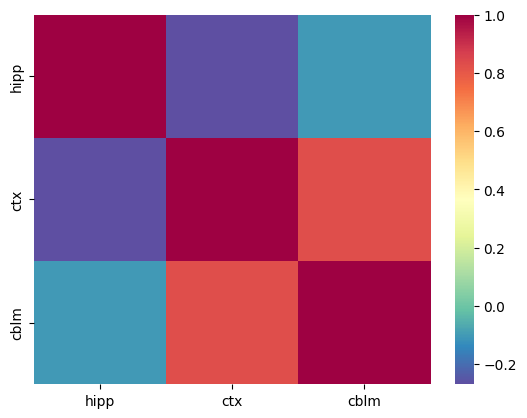

In [342]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='Spectral_r')

Recall that for a dataset with n features, the covariance matrix will be n x n. The (i,j)th entry of the matrix will be the covariance between features i and j, which is just the dot product of the two features, with the mean subtracted. The recipe for computing the covariance of a dataset is as follows: 

1) subtract the mean from each column
2) multiply the data matrix by its transpose
3) divide by the total number of data points

Let's do this in code. First up, calculate the means:

In [343]:
data.mean(axis=0)

array([3.  , 3.75, 8.5 ])

We want to subtract 3 from all the rows of the first column, subtract 3.75 from all the rows of the second column, etc. We have to coax numpy a little bit to do that by 'tiling' the array so it can easily be subtracted from the original array. 

In [345]:
mn = data.mean(axis=0)
data_mean = np.tile(mn, (data.shape[0], 1))

The syntax is basically saying: "take that original 1 x 3 array, and stack it on itself. We want to stack it as many times as we have data points" (that's what data.shape[0] gives us)

In [346]:
data_mean

array([[3.  , 3.75, 8.5 ],
       [3.  , 3.75, 8.5 ],
       [3.  , 3.75, 8.5 ],
       [3.  , 3.75, 8.5 ]])

let's then subtract off the mean, and multiply the matrix by its transpose.

In [349]:
d = data - data_mean
cov = (1/3) * np.matmul(d.T, d)
cov

array([[ 6.        , -3.66666667, -1.66666667],
       [-3.66666667, 30.91666667, 31.16666667],
       [-1.66666667, 31.16666667, 45.66666667]])

Should look pretty familiar! 

In [350]:
df.cov()

,hipp,ctx,cblm
hipp,6.000000,-3.666667,-1.666667
ctx,-3.666667,30.916667,31.166667
cblm,-1.666667,31.166667,45.666667


# Making Fake Data

Generating fake data is a useful skill. Not for reasons of sneakiness or deception, but for generating noisy, probabilistic data with some kind of 'typical' behavior. We use probability to generate 'fake' data from *known* underlying processes, and then use stats to 'recover' an appropriate, probabilistic description of our data. Obviously, in the real work, we're using stats to recover a probabilistic description of our data generating process when we're in the dark about how the data were actually generated. 

To make this concrete, let's think about generating a distribution of resting potentials for a group of 200 neurons. They might have a typical resting potential of around -65mV, and shown normally distributed fluctuations around that value with a standard deviation of ~5 mv. In other words, we'd be not terribly surprised to see values as large as -60 mV, or as small as -70 mV, but we'd be quite surprised to something like -50 mV, or -80 mV. 

We'll create an array, X, with our resting potential values, and initialize it to -65 mV: 

In [351]:
X = np.ones(1000) * -65

The cell above creates an array of 100 ones, and then multiplies it by -65 to give us a 100 dimensional array of -65s. Let's next make some noisy fluctuations with the properties we desire (i.e. mean of zero and standard deviation of 5 mV)

In [352]:
noise = 5 * np.random.randn(1000)  

Our 'fake data' is then just the sum of the deterministic part (-65 mV) + the random part: 

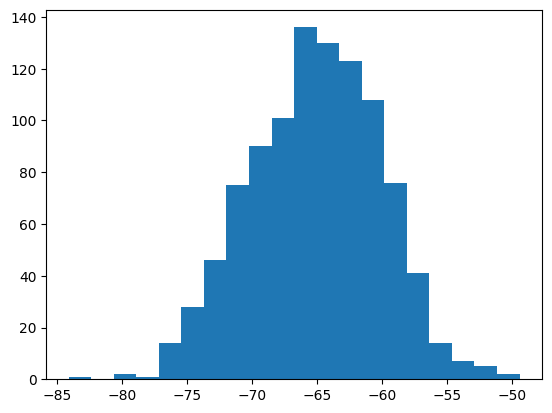

In [353]:
vrest = X + noise
plt.hist(vrest,20);

Let's now assume that a neuron's threshold is described by a relatively simple relationship such that the threshold is 90% the resting potential, plus 15 mV. Or, mathematically: 

V_thresh = 0.9 x V_rest + 15

In [354]:
vthresh = 0.9 * vrest + 15 

If we plot vthresh vs. vrest, we get a line: 

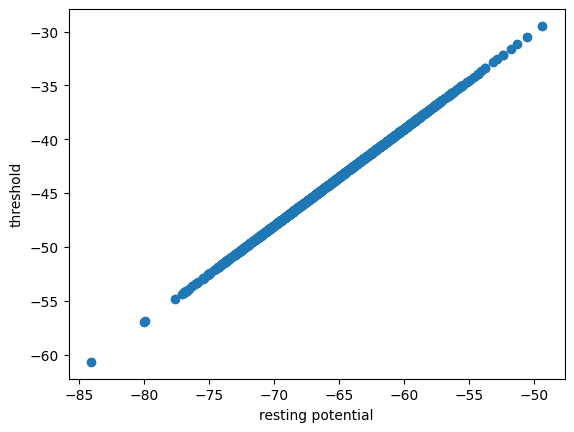

In [355]:
plt.scatter(vrest,vthresh);
plt.xlabel('resting potential');
plt.ylabel('threshold');

You will pretty much never see data that look like that in the wild, unless your two variables just differ by a simple conversion factor (temp in degrees vs. temp in celsius, for example). Instead, the data will *imply* a lawful relationship, but not give it to you for free. You'll observe "basically a line", or "basically a parabola", only with some noisy fluctuation. 

Let's give our data some noisy fluctuations to make it more realistic. 

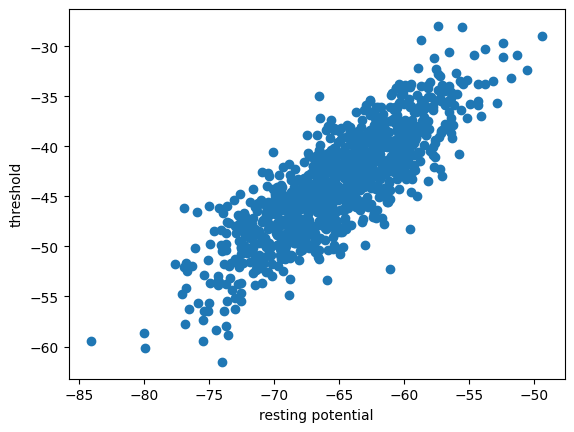

In [356]:
vthresh = vthresh + 3 * np.random.randn(1000)
plt.scatter(vrest,vthresh);
plt.xlabel('resting potential');
plt.ylabel('threshold');

That's better! (Well.. I guess technically 'worse' ;-). Now, please go along with me on following pretense: let's imagine that knew nothing about how those data were generated, and that all we have at our disposal are a list noisy resting potentials, and a list of corresopnding noisy thresholds. We can plot them, and intuit that there's some relationship, but we wish to learn what this is. That's the *statistical* problem that life actually hands us: "Here are some noisy measurements: make some assumptions and try to work your way backwards to an understanding of the true relationship that holds underneath all the noisy fluctuations." 

Remember that of course, we secretly know that the real realtionship is vthresh = 0.9 x vrest + 15. 

If our statistical procedure is able to spit back the numbers 0.9 and 15, that would be pretty cool. 

# Linear Regression

Hidden under all that noise is a line, waiting to be freed! In principle, we could select any of a whole variety of models. Maybe there's some super 'wiggly' relationship that tracks every contour in the data. Maybe a line with a slight bow to it is the best description, etc. Our first job is to pick a magical box. We will create a magical box called LR: 

In [357]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()

The way to think about LR is that it is an object which is all about fitting straight lines to data. All we've done is initialize, or instantiate it. You could think of us as having just created an empty array in numpy, or an empty dataframe in pandas. To breathe life into
LR, we need to feed it some data. When feeding it data, we typically make a distinction between dependent and independent variables. A few terms are worth noting: 

'features'
'targets' 
'independent variable'
'dependent variable'

In [358]:
X = vrest.reshape(-1,1)
y = vthresh.reshape(-1,1)

In [359]:
regr = LR.fit(X,y)

Now, it's not just some generic object, but a special one that has been custom-fitted to our very own data! It has gone through some process which we're not going to worry a ton about (but which we discussed in class a bit) to identify *parameters*.

We can now think of regr as a kind of oracle. We can peek in side and ask, what are the parameters? 

In [360]:
regr.coef_

array([[0.89110013]])

In [361]:
regr.intercept_

array([14.40765922])

What is this telling us? It's saying: "I did the best I can do, and I think what's going on here is that the data were generated by a process that multiplies X by 0.92, and then adds 16.613."

Not a bad job, considering we **know** the data were created by a process that multiplied X by 0.9, and then added 15. We can inspect the model's prediciton by plotting the fitted line on the original graph: 

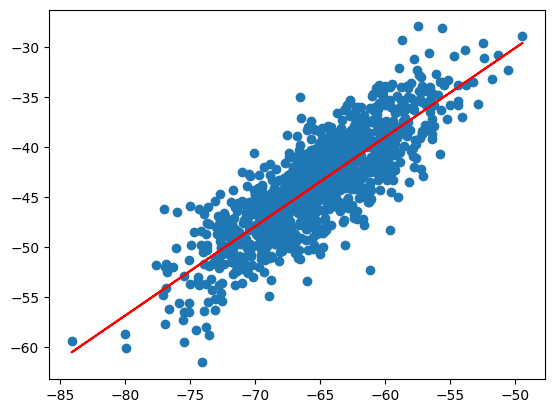

In [362]:
a = regr.coef_
b = regr.intercept_

# our linear prediction
y_predicted = a * vrest + b

# original data w/ linear fit superimposed
plt.scatter(vrest, vthresh)
plt.plot(vrest.reshape(-1,1),y_predicted.reshape(-1,1),'r');

One of the big virtues of having a fitted model is that we can now use it to do *prediction*. Say someone comes along with a measured membrane voltage of -45mV and they wanted to estimate what that neuron's threshold is likely to be. With your formula, this is an easy prediction to do. The regression object we created has a handy syntax for this as well:  

In [363]:
LR.predict(np.array([-45]).reshape(-1,1))

array([[-25.6918468]])

If you look at the red line in the plot above, it certainly seems plausible that at -45 mV, we'd have a y value of ~-25, as predicted. The reshape() command above is just a little bit of hocus-pocus because the predict() function expects arrays to be formatted a certain way. The important thing is that we fed it the number -45, and the model spat back a prediction of around -25. 

We can also ask our model to tell us how good of a job it did by giving us a 'score':

In [364]:
LR.score(X,y)

0.683034791727744

The exact metric being used as a score varies with the choice of model, but in this case the score is the familiar correlation coefficient. Good scores are close to '1'.


# A more complex (and more typical) example

There are some intersting phenomena out there that show linear behavior, but life would be pretty boring if we were limited to linearity. Suppose that the threshold actually had a slightly more complicated dependence on resting potential.

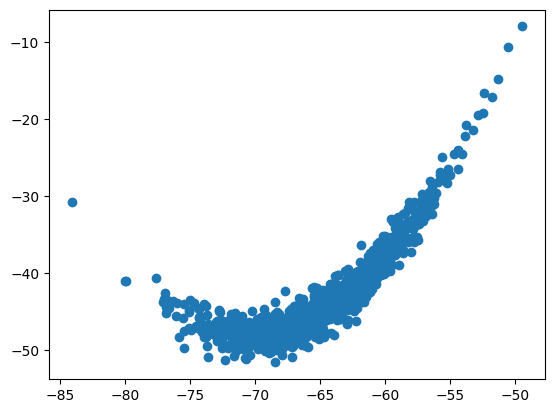

In [365]:
vthresh = 20 + vrest + .09 * (vrest + 65) ** 2 + 1.5 * np.random.randn(1000)
plt.scatter(vrest, vthresh);

Let's just do our analysis all over again and see how we do with a linear fit: 

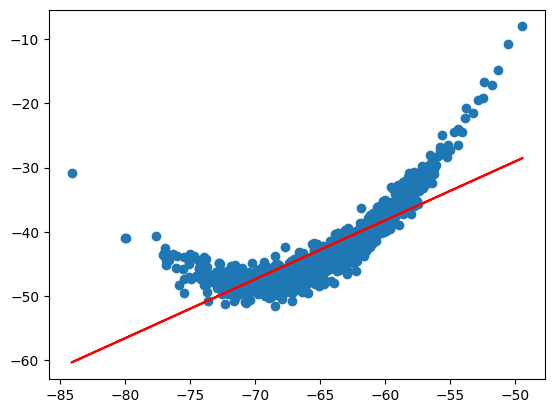

In [366]:
X = vrest.reshape(-1,1)
y = vthresh.reshape(-1,1)

# Initialize a new regression object
LR  = LinearRegression()

# Fit 
regr = LR.fit(X,y)

# Get the model coefficients and use them to predict
a = regr.coef_
b = regr.intercept_

# Get a predicted value for the threshold, based on our fitted model
vthresh_predicted = a * vrest + b 

plt.scatter(vrest, vthresh);
plt.plot(vrest.reshape(-1,1), vthresh_predicted.reshape(-1,1),'r');

Ick. If we ask our model to tell us what we think the threshold is for a neuron with a resting potential of -85, it's going to be disastrously off:

In [367]:
LR.predict(np.array([-80]).reshape(-1,1))

array([[-56.62779531]])

And our overall score is crummy now too....

In [368]:
LR.score(X,y)

0.6440862929904563

This should be pretty unsurprising. I mean, there's only so well a line is going to fit the data if the data aren't linear. 

# Fitting another model

So let's try again. We're going to use a model with a lot more flexibility. Something called K-nearest-neighbors (called 'KNN' for short, sometimes). If linear regression was a toy version of the universe that says "I think there's a simple multiplicative and additive relationship between features", then KNN says: "I think everything can be explained by what my neighbors are doing." We won't go too much into this. I just want to make the important larger point that we can throw lots of different models at the data, and the syntax and procedure is all very similar: 

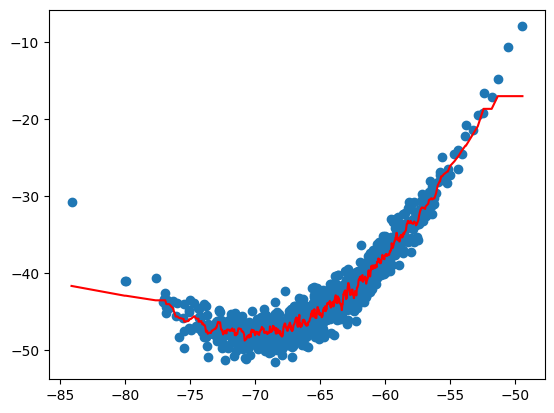

In [369]:
# Import the new model
from sklearn.neighbors import KNeighborsRegressor

# Create an Instance of the model
KNN = KNeighborsRegressor(n_neighbors=10)

# Fit the model
knn = KNN.fit(X,y)

# Make predictions based on the model
knn_predictions = knn.predict(np.sort(X, axis=0))

plt.scatter(vrest, vthresh)
plt.plot(np.sort(vrest,axis=0), knn_predictions, 'r')

When we look at the score this time we see that it's doing quite well: 

In [370]:
knn.score(X,y)

0.9323145499143832

# Making it more real:

Here we do some model-fitting on a real dataset: the ephys data from the Allen Institute. It's illustrative of some of the practical issues you're likely to encounter in the wild. 

In [388]:
from allensdk.core.cell_types_cache import CellTypesCache

ctc = CellTypesCache(manifest_file='cell_types/manifest.json')
features = pd.DataFrame(ctc.get_all_features()).loc[:,'adaptation':'vrest']

Right off the bat, you'll note that we have a decent number of entries where we see NaN instead of an expected numerical value. NaN stands or "not a number", and basically just means that data are missing at that particular entry. Most fitting procedures will yell at you if you try to feed them Nans, so we have to deal with them somehow. There are two basic approaches. 

The first is you can just drop any row that has Nans in it. Let's take a peek at how much data we have in our features dataframe:

In [391]:
features.shape

(701, 56)

Looks like 701 cells. Pandas has a handy function that drop Nans for us, which we can use to aggresively kill all Nans:

In [393]:
features.dropna().shape

(200, 56)

Yikes! that dropped an awful lot of data. Perhaps that's a bit over the top. If a cell is missing one entry for one feature it's going to get dropped using this method. We've thrown away about 500 cells doing this, which is tossing an awful lot of data. Another tool at our disposal is **imputation**, which refers to a set of procedures for trying to fill in nans with some fixed value, or taking a best guess as to what value it should have. Scikit learn has a function called an imputer to help us with this. 

In [452]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()
features_imputed = imputer.fit_transform(features)
features_imputed = pd.DataFrame(data=features_imputed, columns=features.columns)

In [453]:
features_imputed = features_imputed[['f_i_curve_slope', 'input_resistance_mohm', 'tau', 'vrest', 'sag']]

In [454]:
# Let's say we want to try to predict adaptation from the other variables: 

y = features_imputed['f_i_curve_slope'].to_numpy().reshape(-1,1)
X = features_imputed.loc[:,'input_resistance_mohm':].to_numpy()

# The template is exactly the same, that's what makes it so powerful. 
regr = LinearRegression()
regr.fit(X,y)

# If we ask for the coefficients, note that it spits back 4 numbers to us this time. That's because we have 4
# variables that we're asking to explain adaptation. The sizes of the coefficients are telling us the relative 
# importance of variable. Looks like the sag current shows the strongest correlation with adaptation. 

regr.coef_

array([[ 3.73168201e-04, -1.42311268e-02,  6.66147023e-03,
        -7.13264195e-01]])

Let's have a look at the relative contributions of each variable (as indicated by the size of the coefficent from the regression)

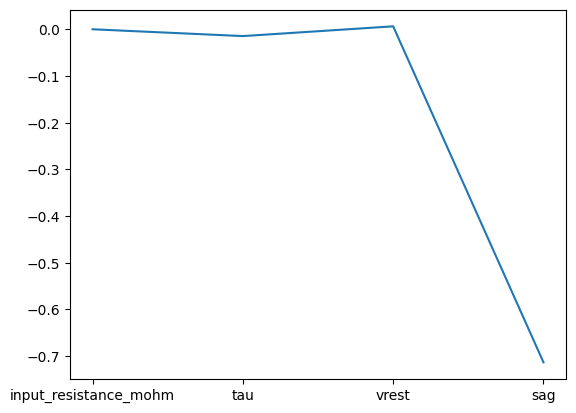

In [455]:
plt.plot(features_imputed.columns[1:].to_numpy(), regr.coef_.reshape(-1,1))

It's fair to ask whether some of those smaller coefficients really matter at all.

In [456]:
regr.score(X,y)

0.22215495618463266

In [457]:
features.columns

Index(['adaptation', 'avg_isi', 'electrode_0_pa', 'f_i_curve_slope',
       'fast_trough_t_long_square', 'fast_trough_t_ramp',
       'fast_trough_t_short_square', 'fast_trough_v_long_square',
       'fast_trough_v_ramp', 'fast_trough_v_short_square', 'has_burst',
       'has_delay', 'has_pause', 'id_x', 'input_resistance_mohm', 'latency',
       'peak_t_long_square', 'peak_t_ramp', 'peak_t_short_square',
       'peak_v_long_square', 'peak_v_ramp', 'peak_v_short_square',
       'rheobase_sweep_id', 'rheobase_sweep_number', 'ri', 'sag', 'seal_gohm',
       'slow_trough_t_long_square', 'slow_trough_t_ramp',
       'slow_trough_t_short_square', 'slow_trough_v_long_square',
       'slow_trough_v_ramp', 'slow_trough_v_short_square', 'specimen_id',
       'tau', 'threshold_i_long_square', 'threshold_i_ramp',
       'threshold_i_short_square', 'threshold_t_long_square',
       'threshold_t_ramp', 'threshold_t_short_square',
       'threshold_v_long_square', 'threshold_v_ramp',
       'thresho

In [460]:
y = features['f_i_curve_slope'].to_numpy().reshape(-1,1)
X = features.loc[:,'fast_trough_t_long_square':].to_numpy()
X = imputer.fit_transform(features)
# The template is exactly the same, that's what makes it so powerful. 
regr = LinearRegression()
regr.fit(X,y)

# If we ask for the coefficients, note that it spits back 4 numbers to us this time. That's because we have 4
# variables that we're asking to explain adaptation. The sizes of the coefficients are telling us the relative 
# importance of variable. Looks like the sag current shows the strongest correlation with adaptation. 

regr.coef_

array([[ 1.90139614e-08,  2.75506650e-11, -1.58262919e-11,
         9.99999998e-01, -2.61483525e-07,  7.92827811e-08,
        -1.38995483e-05, -2.63180516e-09,  2.31439226e-09,
         2.14186295e-09,  2.30689658e-08, -2.79027186e-08,
        -6.67032400e-09,  3.33066907e-16, -1.25353677e-12,
         2.48153045e-08,  8.32864214e-07,  7.31739331e-08,
        -1.47985911e-06,  1.38153392e-10, -2.94854622e-11,
         1.01986526e-10, -6.93753943e-11, -7.79105784e-11,
        -1.16879076e-10,  6.49255098e-10,  2.07757911e-10,
        -3.20163382e-11, -7.09313862e-11,  5.40649605e-10,
         2.88702475e-10, -1.77104325e-11,  7.28648144e-11,
         5.55111512e-17,  3.47306814e-10,  3.62733498e-11,
         1.61930758e-09, -2.98159136e-11, -5.42700276e-07,
        -1.89189132e-07,  1.70591440e-06, -5.97073974e-12,
        -2.20204833e-11, -3.31853156e-11,  6.93752278e-11,
        -3.66250582e-10, -3.21236664e-09, -6.75774316e-10,
         1.50478224e-10,  1.49122117e-10,  3.07404687e-1

In [467]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

d = features_imputed

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [473]:
features_imputed

results = smf.ols('f_i_curve_slope ~ f_i_curve_slope + sag + tau', data=features_imputed).fit()

In [474]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        f_i_curve_slope   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.341e+29
Date:                Sun, 05 Feb 2023   Prob (F-statistic):               0.00
Time:                        06:41:55   Log-Likelihood:                 21797.
No. Observations:                 701   AIC:                        -4.359e+04
Df Residuals:                     697   BIC:                        -4.357e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5.274e-15   8.95e-16     